## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_10-13-04-23.csv', firstRow=294, lastRow=300)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_110423_S295-300.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=68s and ended at t=462s; mass=44.09305g
This equals a volume of 44.181m; expected was 44.614mL; error is 0.969%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.0025 g/s and for 2nd derivative = 0.0006875000000000001 g/s^2


<IPython.core.display.Javascript object>


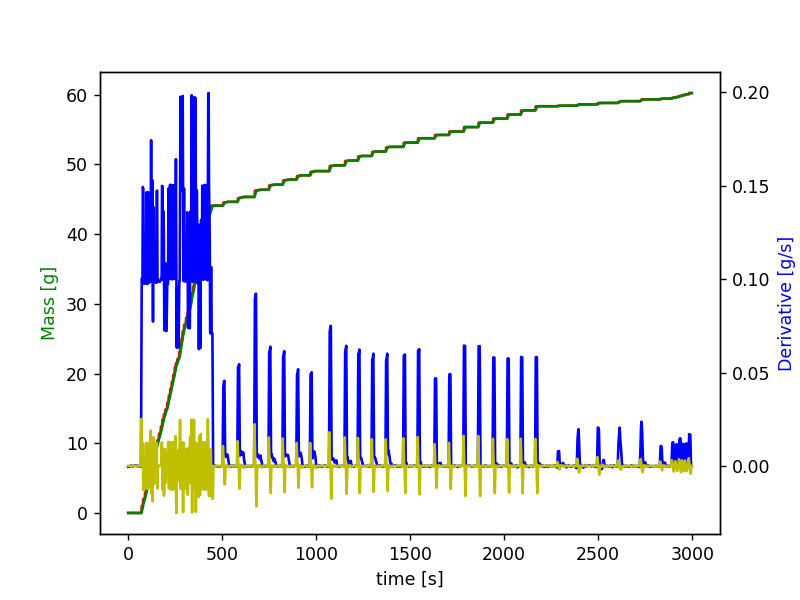

Addition of 0.551g Plantacare 818 detected from 500s to 536s - expected volume = 0.573mL and actual volume = 0.511mL (resulting error is 10.833%)
Addition of 0.704g Plantacare 818 detected from 578s to 624s - expected volume = 0.573mL and actual volume = 0.652mL (resulting error is 13.84%)
Addition of 1.044g Plantacare 818 detected from 668s to 712s - expected volume = 0.994mL and actual volume = 0.966mL (resulting error is 2.803%)
Addition of 0.724g Plantacare 818 detected from 744s to 782s - expected volume = 0.572mL and actual volume = 0.66mL (resulting error is 15.331%)
Addition of 0.729g Plantacare 818 detected from 818s to 858s - expected volume = 0.572mL and actual volume = 0.665mL (resulting error is 16.207%)
Addition of 0.612g Plantacare 818 detected from 892s to 930s - expected volume = 0.519mL and actual volume = 0.556mL (resulting error is 7.087%)
Addition of 0.61g Plantacare 818 detected from 964s to 1002s - expected volume = 0.519mL and actual volume = 0.554mL (resulting 

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.0019375000000000004 g/s and for 2nd derivative = 0.0005625000000000001 g/s^2


<IPython.core.display.Javascript object>


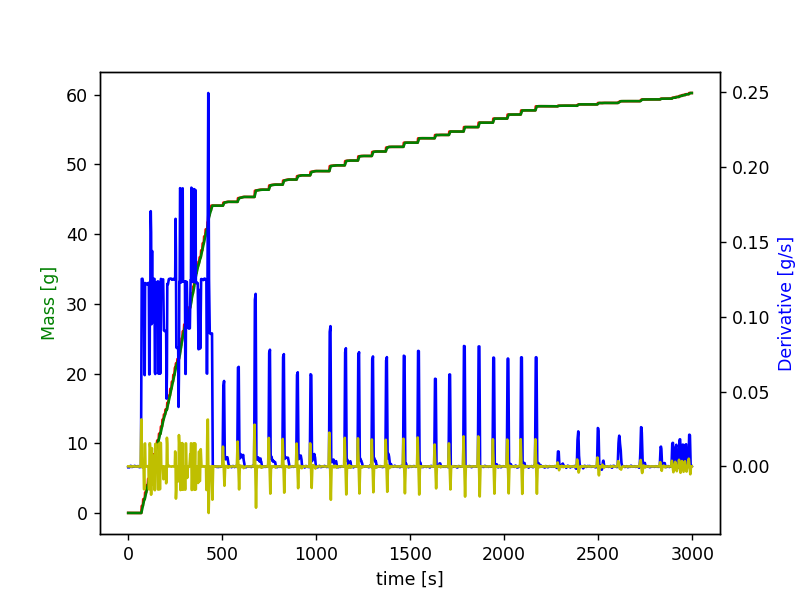

Addition of 0.085g Luviquat Excellence detected from 2182s to 2298s - expected volume = 0.092mL and actual volume = 0.075mL (resulting error is 17.961%)
Addition of 0.196g Luviquat Excellence detected from 2310s to 2406s - expected volume = 0.179mL and actual volume = 0.175mL (resulting error is 2.25%)
Addition of 0.218g Luviquat Excellence detected from 2490s to 2534s - expected volume = 0.193mL and actual volume = 0.2mL (resulting error is 3.555%)
Addition of 0.26g Luviquat Excellence detected from 2602s to 2630s - expected volume = 0.238mL and actual volume = 0.238mL (resulting error is 0.048%)
Addition of 0.261g Luviquat Excellence detected from 2718s to 2754s - expected volume = 0.236mL and actual volume = 0.235mL (resulting error is 0.286%)
Addition of 0.123g Luviquat Excellence detected from 2826s to 2860s - expected volume = 0.1mL and actual volume = 0.11mL (resulting error is 10.473%)


In [13]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=3, mergeSens=8, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

## Analyse Thickeners

In [ ]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=5, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [ ]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_110423_S289-S294.csv', index=False)
actualMassFractions